In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pennylane as qml

from sklearn.model_selection import train_test_split

# Direct classes included for easyness
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Model

In [2]:
# load data
np_data = np.load("data/dataRS.npy")

noise_output = np_data[:,-1].reshape(len(np_data),1)
input = np_data[:,:-1]

# split data
test_split = 0.33
x_train, x_test, y_train, y_test = train_test_split(input, noise_output, test_size=test_split)

### Enter your tag as unique id for saving

In [3]:
tag = str("quantumAutoencoder-18032023")

In [4]:
from pennylane import numpy as np
n_qubits = x_train.shape[1]
compression = 3

dev = qml.device("default.qubit", wires=n_qubits)

Params in the quantum layer to train: 30
0: ──RX(0.05)──Rot(0.68,0.01,0.96)─╭●──────────────────╭●──────────────────╭●─────────────────
1: ──RX(0.45)──Rot(0.09,0.94,0.42)─╰RX(0.75)─╭●────────╰RY(0.33)─╭●────────╰RZ(0.33)─╭●───────
2: ──RX(0.45)──Rot(0.05,0.13,0.08)───────────╰RX(0.42)─╭●────────╰RY(0.17)─╭●────────╰RZ(0.07)
3: ──RX(0.00)──Rot(0.65,0.02,0.57)─────────────────────╰RX(0.58)─╭●────────╰RY(0.55)─╭●───────
4: ──RX(0.43)──Rot(0.96,0.49,0.03)───────────────────────────────╰RX(0.12)───────────╰RY(0.22)

──────────────────────┤     
──────────────────────┤  <Z>
──╭●──────────────────┤  <Z>
──╰RZ(0.69)─╭●────────┤  <Z>
────────────╰RZ(0.78)─┤     


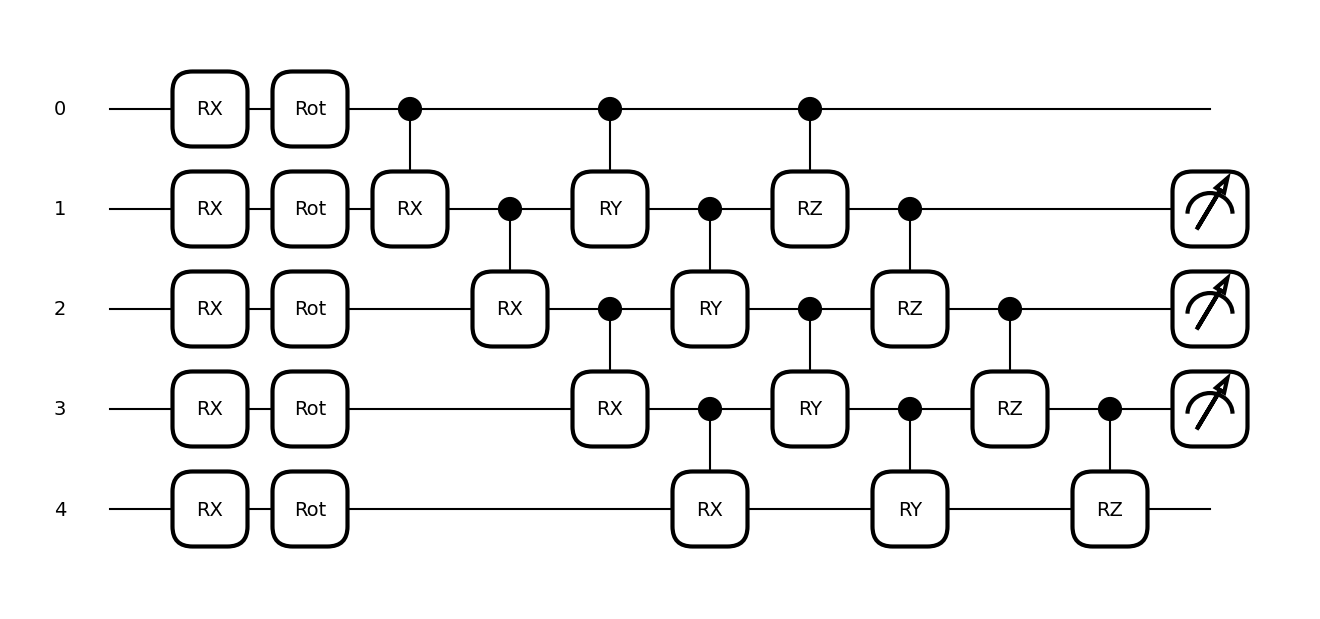

In [5]:
# Encoder
ENC_weight_shapes = {"weight1": (n_qubits,3),
                 "weight2": (n_qubits-1),
                 "weight3": (n_qubits-1),
                 "weight4": (n_qubits-1)}
                #  "weight5": (n_qubits,3)}
nE_qcParams = n_qubits*3+1*3*n_qubits
print(f"Params in the quantum layer to train: {nE_qcParams}")



@qml.qnode(dev)
def encoder(inputs, weight1, weight2, weight3, weight4):#, weight5):
    qml.broadcast(qml.RX, wires=range(n_qubits), parameters=inputs, pattern="single")
    
    qml.broadcast(qml.Rot, wires=range(n_qubits), parameters=weight1, pattern="single")
    qml.broadcast(qml.CRX, wires=range(n_qubits), parameters=weight2, pattern="chain")
    qml.broadcast(qml.CRY, wires=range(n_qubits), parameters=weight3, pattern="chain")
    qml.broadcast(qml.CRZ, wires=range(n_qubits), parameters=weight4, pattern="chain")
    # qml.broadcast(qml.CRot, wires=range(n_qubits), parameters=weight4, pattern="chain")
    # qml.broadcast(qml.Rot, wires=range(n_qubits), parameters=weight5, pattern="single")
    
    return [qml.expval(qml.PauliZ(wires=i+1)) for i in range(compression)]

qEncoder = qml.qnn.KerasLayer(encoder, ENC_weight_shapes, output_dim=n_qubits)

# Visualize the quantum circuit
print(qml.draw(encoder)(x_train[0,:],np.random.rand(n_qubits,3), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1)))#, np.random.rand(n_qubits,3)))
fig1, ax = qml.draw_mpl(encoder)(x_train[0,:],np.random.rand(n_qubits,3), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1))#, np.random.rand(n_qubits,3))
plt.show()
fig1.savefig("archive/Encoder-"+tag+".png")
fig1.savefig("archive/Encoder-"+tag+".pdf")

Params in the quantum layer to train: 30
0: ──Rot(0.57,0.31,0.00)──────────────────────╭●──────────────────╭●──────────────────╭●───────
1: ──RX(0.05)─────────────Rot(0.47,0.07,0.03)─╰RX(0.10)─╭●────────╰RY(0.17)─╭●────────╰RZ(0.59)
2: ──RX(0.45)─────────────Rot(0.70,0.71,0.26)───────────╰RX(0.83)─╭●────────╰RY(0.00)─╭●───────
3: ──RX(0.45)─────────────Rot(0.17,0.66,0.30)─────────────────────╰RX(0.77)─╭●────────╰RY(0.02)
4: ──Rot(0.78,0.68,0.68)────────────────────────────────────────────────────╰RX(1.00)──────────

────────────────────────────────┤  <Z>
──╭●────────────────────────────┤  <Z>
──╰RZ(0.26)─╭●──────────────────┤  <Z>
──╭●────────╰RZ(0.69)─╭●────────┤  <Z>
──╰RY(0.85)───────────╰RZ(0.61)─┤  <Z>


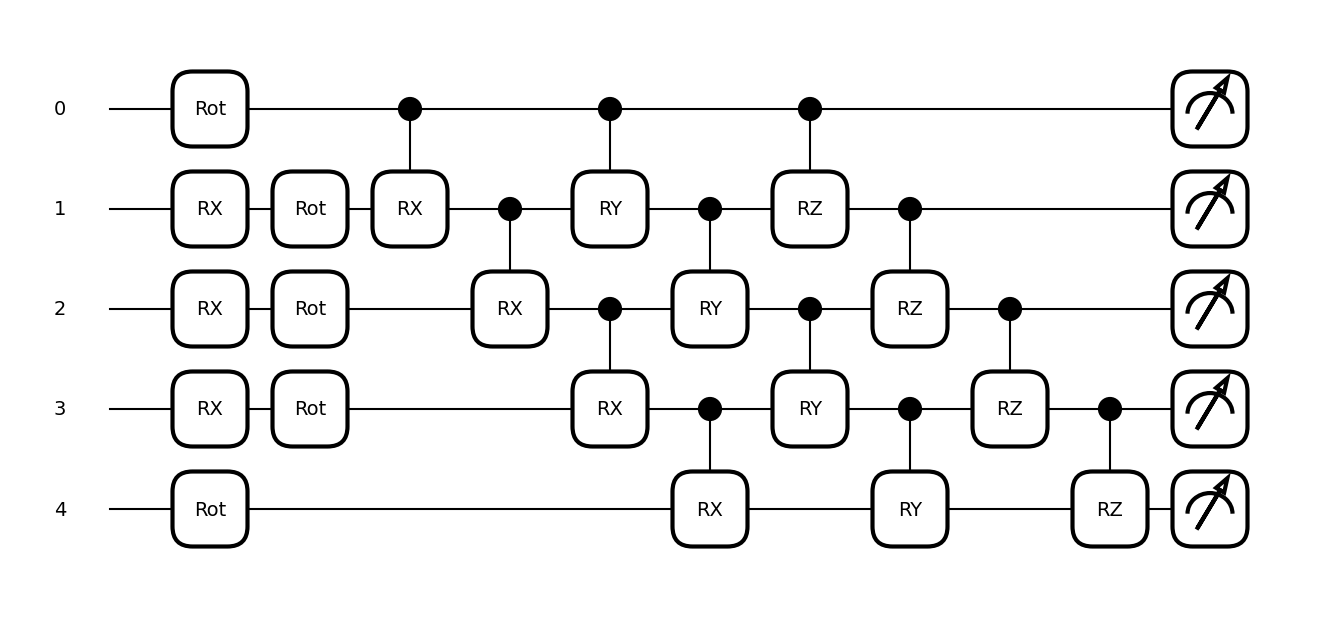

In [6]:
# Decoder
DEC_weight_shapes = {"weight1": (n_qubits,3),
                 "weight2": (n_qubits-1),
                 "weight3": (n_qubits-1),
                 "weight4": (n_qubits-1)}
                #  "weight5": (n_qubits,3)}
nD_qcParams = n_qubits*3+1*3*n_qubits
print(f"Params in the quantum layer to train: {nD_qcParams}")



@qml.qnode(dev)
def decoder(inputs, weight1, weight2, weight3, weight4):#, weight5):
    qml.broadcast(qml.RX, wires=[1,2,3], parameters=inputs, pattern="single")
    
    qml.broadcast(qml.Rot, wires=range(n_qubits), parameters=weight1, pattern="single")
    qml.broadcast(qml.CRX, wires=range(n_qubits), parameters=weight2, pattern="chain")
    qml.broadcast(qml.CRY, wires=range(n_qubits), parameters=weight3, pattern="chain")
    qml.broadcast(qml.CRZ, wires=range(n_qubits), parameters=weight4, pattern="chain")
    # qml.broadcast(qml.CRot, wires=range(n_qubits), parameters=weight2, pattern="chain")
    # qml.broadcast(qml.Rot, wires=range(n_qubits), parameters=weight5, pattern="single")
    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qDecoder = qml.qnn.KerasLayer(decoder, DEC_weight_shapes, output_dim=n_qubits)

# Visualize the quantum circuit
print(qml.draw(decoder)(x_train[0,:3],np.random.rand(n_qubits,3), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1)))#, np.random.rand(n_qubits,3)))
fig2, ax = qml.draw_mpl(decoder)(x_train[0,:3],np.random.rand(n_qubits,3), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1))#, np.random.rand(n_qubits,3))
plt.show()
fig2.savefig("archive/Decoder-"+tag+".png")
fig2.savefig("archive/Decoder-"+tag+".pdf")

In [7]:
#Create a autoencode like in https://blog.keras.io/building-autoencoders-in-keras.html
clear_session()

inputLayer = Input(shape=(x_train.shape[1],))
encoded = qEncoder(inputLayer)
decoded = qDecoder(encoded)
autoencoder = Model(inputLayer, decoded)
print(f"Params in all quantum layers to train: {nD_qcParams+nE_qcParams}")
autoencoder.summary()
plot_model(autoencoder,"archive/model"+tag+".png")

Params in all quantum layers to train: 60
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 keras_layer (KerasLayer)    (None, 5)                 0 (unused)
                                                                 
 keras_layer_1 (KerasLayer)  (None, 5)                 0 (unused)
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [8]:
# Encoder
encoder = Model(inputLayer, encoded)
# Decoder
encoded_input = Input(shape=(compression,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [9]:
# Test Learning Rate Scheduler Parameters
print(.1* tf.math.exp(-2.3))

tf.Tensor(0.010025885, shape=(), dtype=float32)


In [10]:
#Training
#['mean_squared_error', 'mean_absolute_error','mean_squared_logarithmic_error', 'mean_absolute_percentage_error']

def scheduler(epoch, lr):
    if epoch < 8:
        return lr
    else:
        return lr* tf.math.exp(-0.1)
LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", min_delta=0.001, patience=20)

optRMS = tf.keras.optimizers.RMSprop(learning_rate=0.05)

autoencoder.compile(optimizer = optRMS, loss='mean_squared_error', metrics=['mean_absolute_error'])

autoencoder_history = autoencoder.fit(x_train, x_train, epochs=50, batch_size=25, validation_split=0.25, callbacks=[EarlyStopping, LearningRateScheduler])

Epoch 1/100
31/31 [==============================] - 202s 7s/step - loss: 0.0591 - mean_absolute_error: 0.1885 - val_loss: 0.0272 - val_mean_absolute_error: 0.1234
Epoch 2/100
31/31 [==============================] - 209s 7s/step - loss: 0.0247 - mean_absolute_error: 0.1187 - val_loss: 0.0225 - val_mean_absolute_error: 0.1135
Epoch 3/100
31/31 [==============================] - 187s 6s/step - loss: 0.0229 - mean_absolute_error: 0.1113 - val_loss: 0.0248 - val_mean_absolute_error: 0.1224
Epoch 4/100
31/31 [==============================] - 194s 6s/step - loss: 0.0230 - mean_absolute_error: 0.1106 - val_loss: 0.0292 - val_mean_absolute_error: 0.1430
Epoch 5/100
31/31 [==============================] - 193s 6s/step - loss: 0.0230 - mean_absolute_error: 0.1113 - val_loss: 0.0206 - val_mean_absolute_error: 0.1009
Epoch 6/100
31/31 [==============================] - 211s 7s/step - loss: 0.0223 - mean_absolute_error: 0.1084 - val_loss: 0.0237 - val_mean_absolute_error: 0.1171
Epoch 7/100
31/3

In [ ]:
import numpy as np

def plot_metrics(history):
    n = len(history.history.keys())//2
    fig,axs = plt.subplots(1,n, figsize=(18,5))

    for i,[key,val] in enumerate(history.history.items()):
        axs[i%n].plot(history.history[key], lw=4, label=key.replace("_", " "))
    
    for ax in axs:
        #ax.set_yscale("log")
        ax.set_xlabel("epoch", fontsize=16)
        ax.legend(fontsize=14)
plot_metrics(autoencoder_history)
plt.savefig("archive/history-"+tag+".png")

In [ ]:
fig = plt.figure()
plt.plot(autoencoder_history.history['loss'], lw=4, label='loss')
plt.plot(autoencoder_history.history['val_loss'], lw=4, label='val_loss')
plt.plot(autoencoder_history.history['lr'], lw=4, label='lr')
plt.xlabel("epoch", fontsize=16)
plt.legend(fontsize=14)
plt.show()
fig.savefig("archive/history-"+tag+".png")

In [ ]:
evaluation = autoencoder.evaluate(x_test[:-1], x_test[:-1])
encoded_test = encoder.predict(x_test)
decoded_test = decoder.predict(encoded_test)
print(f'Data: {x_test[0,:]} to be: {encoded_test[0,:]} and rebuilded it to: {decoded_test[0,:]}')

In [ ]:
encoder.save("archive/encoderModel-"+tag+".h5")
autoencoder.save("archive/completeModel-"+tag+".h5")
config = encoder.get_config()
np.save("archive/encoderConfig-"+tag+".npy", config)
config = autoencoder.get_config()
np.save("archive/completeConfig-"+tag+".npy", config)

In [ ]:
autoencoder.summary()